# Assignment 2


Ignacio González García-Valdés

#### TARGET VARIABLE

The target variable for this dataset is the following: isFraud

#### ASSIGNMENT OBJECTIVE

We are possibly facing a set of synthetic data from a financial institution. According to the data, the objective of the assignment involves fraudulent transactions detection.

The objective is to generate a model that, given a transaction, emits the probability of existing fraud. Additionally, it is basic to analyze the data, search for profiles, generate the appropriate descriptors, selection and transformation of variables, etc.

#### DOCUMENT OBJECTIVE

In this document, 01_Problem_EDA, the exploratory analysis of the variables that comprise the dataset will be conducted.

###### Libraries

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import chi2_contingency
import warnings
from termcolor import colored as cl
import scipy.stats as ss

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

##### Functions

In [166]:
def cramers_v(confusion_matrix):
    """ 
    calculate Cramers V statistic for categorial-categorial association.
    uses correction from Bergsma and Wicher,
    Journal of the Korean Statistical Society 42 (2013): 323-328
    
    confusion_matrix: tabla creada con pd.crosstab()
    
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
    
def get_corr_matrix(dataset = None, metodo='pearson', size_figure=[10,8]):
    # Para obtener la correlación de Spearman, sólo cambiar el metodo por 'spearman'

    if dataset is None:
        print(u'\nHace falta pasar argumentos a la función')
        return 1
    sns.set(style="white")
    # Compute the correlation matrix
    corr = dataset.corr(method=metodo) 
    # Set self-correlation to zero to avoid distraction
    for i in range(corr.shape[0]):
        corr.iloc[i, i] = 0
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=size_figure)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, center=0,
                square=True, linewidths=.5,  cmap ='viridis' ) #cbar_kws={"shrink": .5}
    plt.show()
    
    return 0

def get_transactions_info(df, fraudulent_transactions, genuine_transactions):

    total_cases = len(df)
    
    fraudulent_count = len(fraudulent_transactions)
    genuine_count = len(genuine_transactions)
    fraudulent_percent = round(fraudulent_count/total_cases*100, 4)

    print(cl('TRANSACTIONS INFORMATION IN THE DATASET', attrs=['bold'], color='green'))
    print(cl('--------------------------------------------------',
          attrs = ['bold'], color='green'))
    print(cl('Total Number of Transactions are {}'.format(
        total_cases), attrs = ['bold'], color='green'))
    print(cl('Number of Genuine Transactions are {}'.format(
        genuine_count), attrs=['bold'], color='green'))
    print(cl('Number of Fraudulent Transactions are {}'.format(
        fraudulent_count), attrs=['bold'], color='green'))
    print(cl('Percentage of Fraud Transactions is {}%'.format(
        fraudulent_percent), attrs=['bold'], color='green'))
    print(cl('--------------------------------------------------',
          attrs=['bold'], color='green'))

    cases = ["Genuine Cases", "Fraudulent Cases"]
    colors = ["lawngreen", "deeppink"]

    data = [genuine_count, fraudulent_count]
    explode = (0, 0.1)
    LEFT = 0.47
    BOTTOM = 0.4
    WIDTH = 0.45
    HEIGHT = 0.45

    # Graphical representation of the imbalanced data
    fig, axes = plt.subplots(figsize=(30, 10))
    ax = fig.add_axes([LEFT, BOTTOM, WIDTH, HEIGHT])

    axes.bar(
        cases,
        data,
        color = colors,
    )
    axes.set_ylabel("Number of Cases", fontsize=13)
    axes.set_ylim(0, 1200000)
    axes.tick_params(axis="x", labelsize=14)
    axes.bar_label(axes.containers[0], padding=4, fontsize = 14)
    ax.pie(
        data,
        labels = cases,
        explode = explode,
        shadow = True,
        colors = colors,
        autopct = "%.2f%%",
        textprops = {"fontsize": 14},
    )
    fig.suptitle("Genuine and Fraudulent Cases of Transactions (Imbalanced Data)", fontsize = 16)
    plt.show()
    
def get_outliers(df):
    
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    
    return ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()

def get_simple_graph(df, col_name, col_target):
    
    plt.figure(figsize=(15,5))

    plt.subplot(1,2,1)
    sns.histplot(df[df.isFraud == 1], x = col_name, hue = col_target)
    
def get_histogram_numeric(df, numeric_variables):
    
    plt.figure(figsize=(20,8))

    for variable in numeric_variables:
      plt.subplot(2,3,numeric_variables.index(variable)+1)
      sns.distplot(df[variable])
    plt.show()
    
def get_corr_cat(df, categorical_variables):
    
    for variable in categorical_variables:
    
        confusion_matrix = pd.crosstab(df[variable], df["isFraud"])
        print(variable + ' frente a isFraud')
        print(cramers_v(confusion_matrix.values))
    
def plot_feature(df, col_name, target =  'isFraud'):
   
    if col_name== target:
        f, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12,3), dpi=90)
        sns.countplot(x=df[target], ax=ax1);
        ax1.set_xlabel(col_name)
        ax1.set_ylabel('Número')
      
    else:
        f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
        sns.countplot(x=df[col_name], color='#5975A4', saturation=1, ax=ax1)
        
        if df[col_name].nunique() <= 20:
            ax1.set_xlabel(col_name)
            plt.xticks(rotation = 90)
        else:
            ax1.axes.get_xaxis().set_ticks([])
        ax1.set_ylabel('Número')
  
        data = (df.groupby(col_name)[target].value_counts(normalize=True).to_frame('proporción').reset_index())
        data_isfraud = data['isFraud'] == 1
        data = data[data_isfraud]

        
        data.columns = [col_name, target, 'proporción']
       
        sns.barplot(x = col_name,
                    y = 'proporción',
                     
                    data = data, 
                    saturation=1,
                    ax=ax2,
                    )
        
        ax2.set_ylabel(target)
        ax2.set_title(target)
        
        if df[col_name].nunique() <= 20:
            ax2.set_xlabel(col_name)
            plt.xticks(rotation = 90)
           
        else:
            ax2.axes.get_xaxis().set_ticks([])

        plt.tight_layout()

def plot_several_features(list_variables):

    for variable in list_variables:
        
        plot_feature(fraud_df, variable, target =  'isFraud')
        
def get_transaction_nature(df):
    
    df["Transaction_nature"] = np.nan 

    df.loc[df.nameOrig.str.contains('C') & df.nameDest.str.contains('C'), "Transaction_nature"] = "C_C" 
    df.loc[df.nameOrig.str.contains('C') & df.nameDest.str.contains('M'), "Transaction_nature"] = "C_M"
    df.loc[df.nameOrig.str.contains('M') & df.nameDest.str.contains('C'), "Transaction_nature"] = "M_C"
    df.loc[df.nameOrig.str.contains('M') & df.nameDest.str.contains('M'), "Transaction_nature"] = "M_M"                  

##### Parametrisation

In [182]:
csv_path = '../data/Original_dataset_payments_fraud.csv'
csv_outpath = '../data/fraud_dataset_EDA.csv'

##### Warnings

In [5]:
warnings.filterwarnings('ignore')

##### Dictionary

##### Data

In [184]:
fraud_df = pd.read_csv(csv_path, sep = ';')

We print the head values of the dataframe to see the state of the data. In this way, we can see if the data requires some kind of adjustment.

In [7]:
fraud_df.head()

,step,type,amount,gender,device,connection_time,nameOrig,race,oldbalanceOrg,age,newbalanceOrig,zone,user_number,nameDest,user_connections,security_alert,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,man,mac,"0,140039412",C1231006815,black,170136.0,85,160296.36,capital,138,M1979787155,5,1,0.0,0.0,0
1,1,PAYMENT,1864.28,woman,mac,"0,496889534",C1666544295,asian,21249.0,57,19384.72,country,909,M2044282225,1,0,0.0,0.0,0
2,1,TRANSFER,181.00,man,pc,"0,781150327",C1305486145,asian,181.0,66,0.00,capital,2569,C553264065,10,0,0.0,0.0,1
3,1,CASH_OUT,181.00,man,mac,"0,565068378",C840083671,black,181.0,31,0.00,country,1787,C38997010,3,0,21182.0,0.0,1
4,1,PAYMENT,11668.14,unknow,mac,"0,517114493",C2048537720,black,41554.0,90,29885.86,country,3997,M1230701703,8,0,0.0,0.0,0


We can see that all the variables are fine, except for connection_time, which has a comma instead of a dot. This can cause problems later. As the first change, we will adjust this variable in order to don´t have problems later.

In [8]:
fraud_df['connection_time'] = fraud_df['connection_time'].str.replace(',' , '.')

In [9]:
fraud_df.head()

,step,type,amount,gender,device,connection_time,nameOrig,race,oldbalanceOrg,age,newbalanceOrig,zone,user_number,nameDest,user_connections,security_alert,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,man,mac,0.140039412,C1231006815,black,170136.0,85,160296.36,capital,138,M1979787155,5,1,0.0,0.0,0
1,1,PAYMENT,1864.28,woman,mac,0.496889534,C1666544295,asian,21249.0,57,19384.72,country,909,M2044282225,1,0,0.0,0.0,0
2,1,TRANSFER,181.00,man,pc,0.781150327,C1305486145,asian,181.0,66,0.00,capital,2569,C553264065,10,0,0.0,0.0,1
3,1,CASH_OUT,181.00,man,mac,0.565068378,C840083671,black,181.0,31,0.00,country,1787,C38997010,3,0,21182.0,0.0,1
4,1,PAYMENT,11668.14,unknow,mac,0.517114493,C2048537720,black,41554.0,90,29885.86,country,3997,M1230701703,8,0,0.0,0.0,0


## Exploratory Data Analysis and Preprocessing

### Set dimensions

In [10]:
fraud_df.shape

(1048575, 19)

The dataset contains 1,048,575 rows and 19 columns.

### Columns

In [11]:
fraud_df_columns = fraud_df.columns

We store them in a variable in case we need them later.

In [12]:
fraud_df_columns

Index(['step', 'type', 'amount', 'gender', 'device', 'connection_time',
       'nameOrig', 'race', 'oldbalanceOrg', 'age', 'newbalanceOrig', 'zone',
       'user_number', 'nameDest', 'user_connections', 'security_alert',
       'oldbalanceDest', 'newbalanceDest', 'isFraud'],
      dtype='object')

### Variable information

In [13]:
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 19 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   step              1048575 non-null  int64  
 1   type              1048575 non-null  object 
 2   amount            1048575 non-null  float64
 3   gender            943457 non-null   object 
 4   device            943995 non-null   object 
 5   connection_time   1048575 non-null  object 
 6   nameOrig          1048575 non-null  object 
 7   race              943412 non-null   object 
 8   oldbalanceOrg     1048575 non-null  float64
 9   age               1048575 non-null  int64  
 10  newbalanceOrig    1048575 non-null  float64
 11  zone              944161 non-null   object 
 12  user_number       1048575 non-null  int64  
 13  nameDest          1048575 non-null  object 
 14  user_connections  1048575 non-null  int64  
 15  security_alert    1048575 non-null  int64  
 16  

In [14]:
fraud_df.dtypes.sort_values().to_frame('feature_type').groupby(by = 'feature_type').size().to_frame('count').reset_index()

,feature_type,count
0,int64,6
1,float64,5
2,object,8


As we can see the connection time variable that we previously changed is an object when it should be a float. We change it.

In [15]:
fraud_df['connection_time'] = fraud_df['connection_time'].astype('float64')

In [16]:
fraud_df['connection_time'].dtypes

dtype('float64')

In [17]:
fraud_df.dtypes.sort_values().to_frame('feature_type').groupby(by = 'feature_type').size().to_frame('count').reset_index()

,feature_type,count
0,int64,6
1,float64,6
2,object,7


The change has been made successfully. We currently have 12 numerical and 7 categorical variables.

### Duplicated values

In [18]:
fraud_df.duplicated().value_counts()

False    1048575
dtype: int64

It has no duplicate values so we do nothing.

### Null values observation

In [20]:
fraud_df_dtypes = pd.merge(fraud_df.isnull().sum(axis = 0).sort_values().to_frame('missing_value').reset_index(),
         fraud_df.dtypes.to_frame('feature_type').reset_index(),
         on = 'index',
         how = 'inner')

In [21]:
fraud_df_dtypes.sort_values(['missing_value', 'feature_type'])

,index,missing_value,feature_type
0,step,0,int64
2,security_alert,0,int64
3,user_connections,0,int64
5,user_number,0,int64
8,age,0,int64
14,isFraud,0,int64
1,oldbalanceDest,0,float64
6,newbalanceOrig,0,float64
7,newbalanceDest,0,float64
10,connection_time,0,float64


We have 4 variables with the presence of nulls. Let's look at variables.

In [22]:
null = fraud_df.isna().sum()
null[null > 0].sort_values()

zone      104414
device    104580
gender    105118
race      105163
dtype: int64

We have quite a few nulls. Therefore, we will have to decide whether to treat them or not and in what way.

In [23]:
null_columns = ['zone','device','gender','race']

In [24]:
null_columns

['zone', 'device', 'gender', 'race']

We change the null values for not available since we do not know that data and we check.

In [25]:
fraud_df[null_columns]=fraud_df[null_columns].fillna('missing')
fraud_df.isna().sum().sum()

0

In [26]:
null = fraud_df.isna().sum()
null[null > 0].sort_values()

Series([], dtype: int64)

Nans fixed

## Outliers observation

In [27]:
outliers_numbers = get_outliers(fraud_df)

In [28]:
print(outliers_numbers)

age                      0
amount               53088
connection_time          0
device                   0
gender                   0
isFraud               1142
nameDest                 0
nameOrig                 0
newbalanceDest      114557
newbalanceOrig      170244
oldbalanceDest      125403
oldbalanceOrg       181877
race                     0
security_alert      104905
step                 17974
type                     0
user_connections         0
user_number              0
zone                     0
dtype: int64


Outlier values can be substituted for mean, median, extreme values. After the following analysis, I have decided to leave them without replacement, since the outliers may have some value since they are located in columns like security_alert ,newbalance and therefore may correspond to frauds.

### Objective variable analysis

In [29]:
fraud_df

,step,type,amount,gender,device,connection_time,nameOrig,race,oldbalanceOrg,age,newbalanceOrig,zone,user_number,nameDest,user_connections,security_alert,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,man,mac,0.140039,C1231006815,black,170136.00,85,160296.36,capital,138,M1979787155,5,1,0.00,0.00,0
1,1,PAYMENT,1864.28,woman,mac,0.496890,C1666544295,asian,21249.00,57,19384.72,country,909,M2044282225,1,0,0.00,0.00,0
2,1,TRANSFER,181.00,man,pc,0.781150,C1305486145,asian,181.00,66,0.00,capital,2569,C553264065,10,0,0.00,0.00,1
3,1,CASH_OUT,181.00,man,mac,0.565068,C840083671,black,181.00,31,0.00,country,1787,C38997010,3,0,21182.00,0.00,1
4,1,PAYMENT,11668.14,unknow,mac,0.517114,C2048537720,black,41554.00,90,29885.86,country,3997,M1230701703,8,0,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,95,CASH_OUT,132557.35,woman,mac,0.420243,C1179511630,black,479803.00,39,347245.65,missing,3179,C435674507,9,0,484329.37,616886.72,0
1048571,95,PAYMENT,9917.36,woman,mac,0.376169,C1956161225,black,90545.00,36,80627.64,africa,2558,M668364942,9,0,0.00,0.00,0
1048572,95,PAYMENT,14140.05,unknow,pc,0.837109,C2037964975,black,20545.00,31,6404.95,africa,1553,M1355182933,2,0,0.00,0.00,0
1048573,95,PAYMENT,10020.05,man,mac,0.480931,C1633237354,black,90605.00,94,80584.95,country,642,M1964992463,8,0,0.00,0.00,0


In [30]:
fraud_df[['type','isFraud']].groupby('type').sum()

,isFraud
type,
CASH_IN,0
CASH_OUT,578
DEBIT,0
PAYMENT,0
TRANSFER,564


None


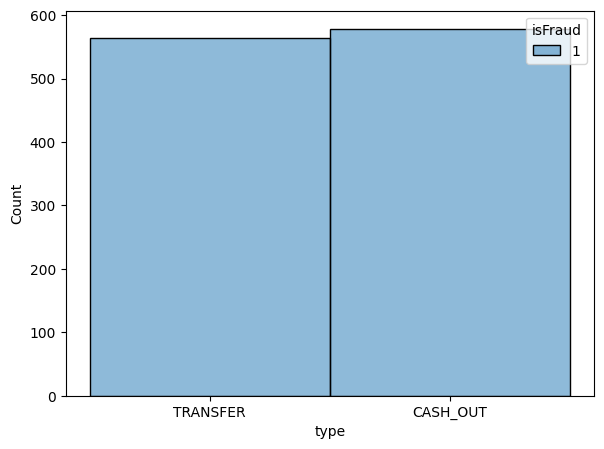

In [31]:
print(get_simple_graph(fraud_df, 'type', 'isFraud'))

As we can see, there are only two categories of fraud: Cash_out and Transfer. Therefore it will be these categories that interest us. Therefore they will be very important to make the model. We can also see that fraud is evenly distributed between these two categories.

We create two dataframes with the respective data of the objective variable

In [32]:
fraudulent_transactions = fraud_df.query("isFraud==1")
genuine_transactions = fraud_df.query("isFraud==0")

In [33]:
fraudulent_transactions.head(30)

,step,type,amount,gender,device,connection_time,nameOrig,race,oldbalanceOrg,age,newbalanceOrig,zone,user_number,nameDest,user_connections,security_alert,oldbalanceDest,newbalanceDest,isFraud
2,1,TRANSFER,181.00,man,pc,0.781150,C1305486145,asian,181.00,66,0.00,capital,2569,C553264065,10,0,0.00,0.00,1
3,1,CASH_OUT,181.00,man,mac,0.565068,C840083671,black,181.00,31,0.00,country,1787,C38997010,3,0,21182.00,0.00,1
251,1,TRANSFER,2806.00,unknow,pc,0.850314,C1420196421,asian,2806.00,90,0.00,africa,1413,C972765878,7,0,0.00,0.00,1
252,1,CASH_OUT,2806.00,missing,mac,0.331417,C2101527076,asian,2806.00,94,0.00,capital,2370,C1007251739,6,0,26202.00,0.00,1
680,1,TRANSFER,20128.00,woman,pc,0.762768,C137533655,asian,20128.00,6,0.00,country,3133,C1848415041,3,0,0.00,0.00,1
681,1,CASH_OUT,20128.00,man,mac,0.506713,C1118430673,asian,20128.00,85,0.00,africa,2963,C339924917,5,0,6268.00,12145.85,1
724,1,CASH_OUT,416001.33,man,missing,0.937052,C749981943,asian,0.00,10,0.00,africa,3470,C667346055,1,0,102.00,9291619.62,1
969,1,TRANSFER,1277212.77,woman,pc,0.738501,C1334405552,asian,1277212.77,48,0.00,africa,546,C431687661,5,0,0.00,0.00,1
970,1,CASH_OUT,1277212.77,woman,mac,0.416068,C467632528,black,1277212.77,7,0.00,africa,111,C716083600,2,0,0.00,2444985.19,1
1115,1,TRANSFER,35063.63,unknow,pc,0.812784,C1364127192,asian,35063.63,100,0.00,capital,4872,C1136419747,2,0,0.00,0.00,1


Something that can be observed as a result of this new dataframe that we have created, is that we found many cases (at least in the sample that we have taken 30) in which, firstly a transfer occurs and then (by the index we can see it) a cashout takes plalce leaving the account at 0 euros. This must be taken into account when making the model.

TRANSACTIONS INFORMATION IN THE DATASET
--------------------------------------------------
Total Number of Transactions are 1048575
Number of Genuine Transactions are 1047433
Number of Fraudulent Transactions are 1142
Percentage of Fraud Transactions is 0.1089%
--------------------------------------------------


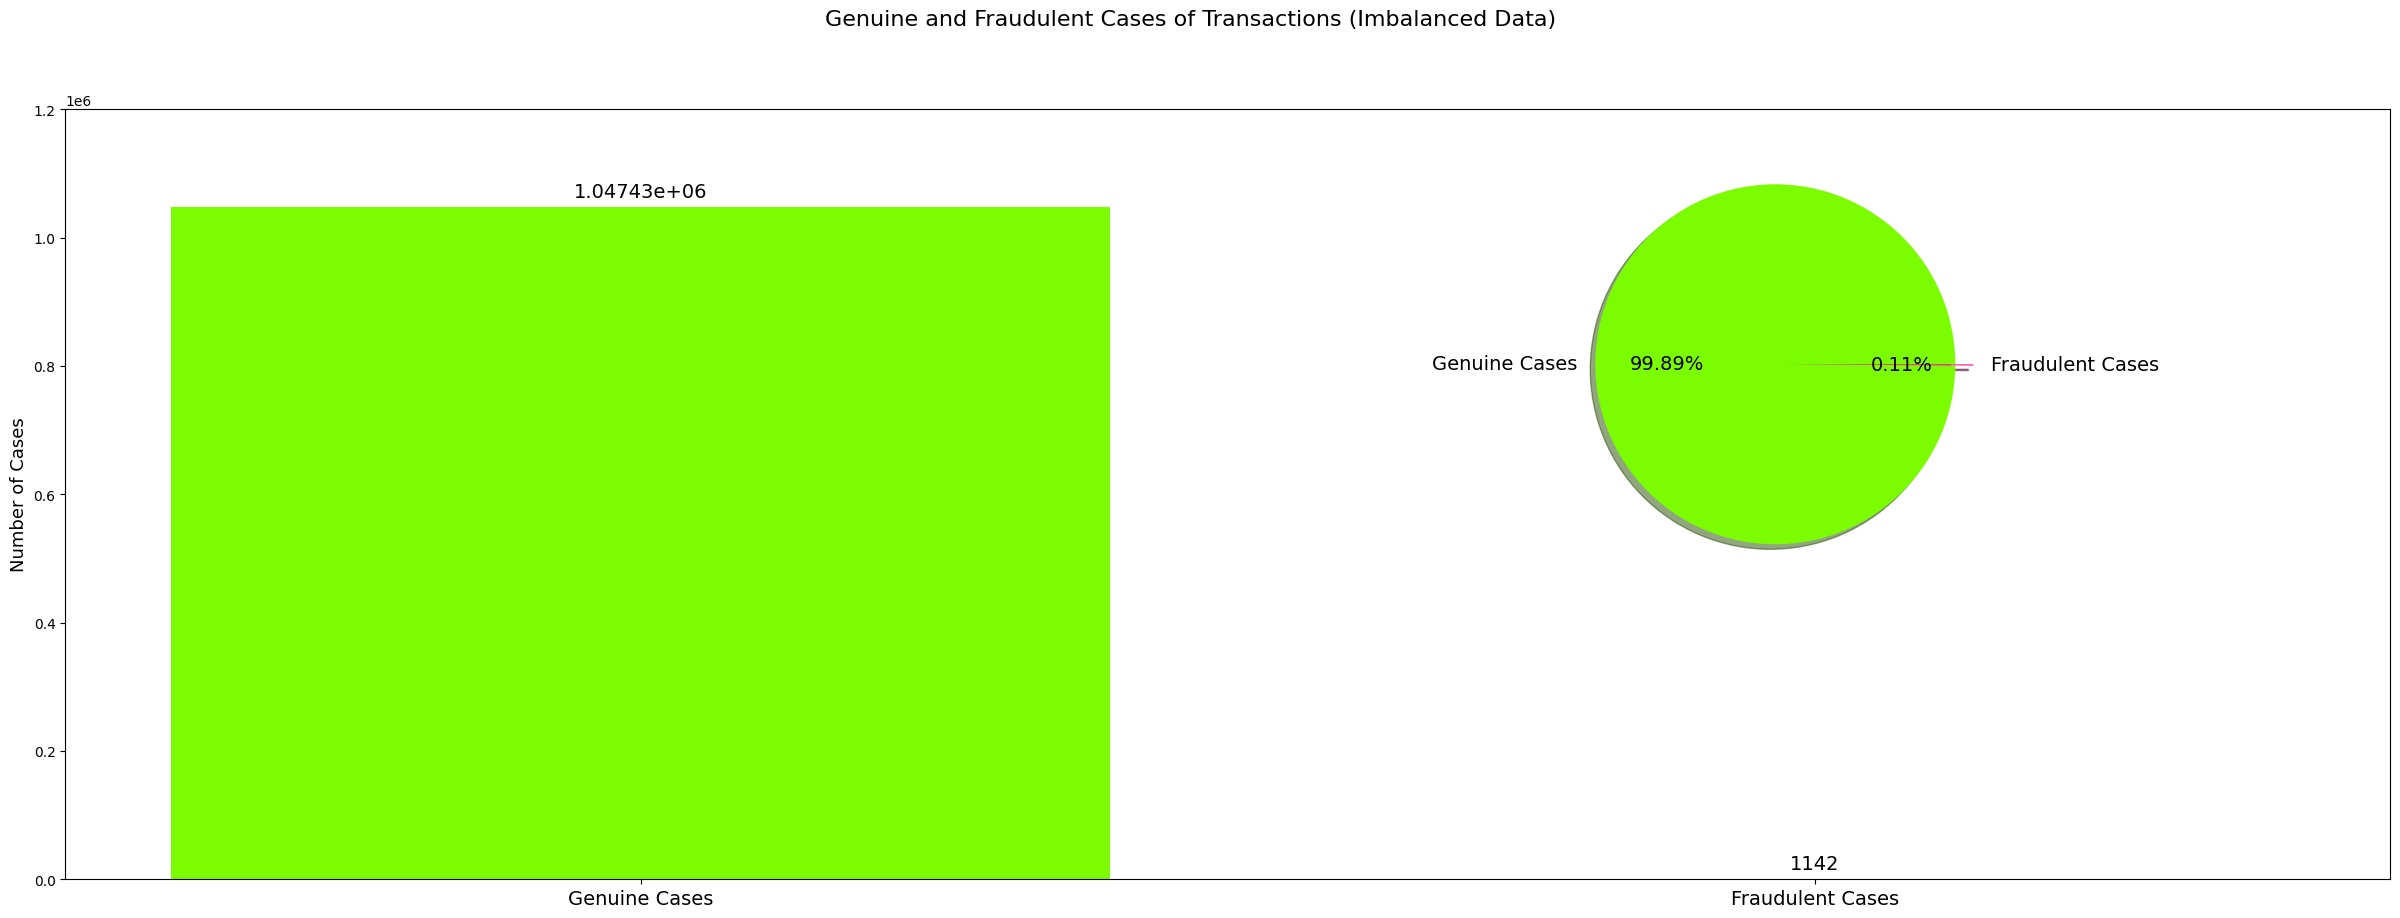

In [34]:
get_transactions_info(fraud_df, fraudulent_transactions, genuine_transactions)

As we can see, fraudulent cases represent a very small part of the dataset. To be exact, there are 1,142 cases in which fraud is committed.

## VARIABLES ANALYSIS

### Categorical variables 

We select the categorical variables in order to create the corresponding matrix.

In [35]:
categorical_column_names = [ 'gender', 'device', 'nameOrig', 'race', 'zone', 'nameDest', 'type']

In [36]:
categorical_variables = fraud_df[categorical_column_names]

In [37]:
categorical_variables.head()

,gender,device,nameOrig,race,zone,nameDest,type
0,man,mac,C1231006815,black,capital,M1979787155,PAYMENT
1,woman,mac,C1666544295,asian,country,M2044282225,PAYMENT
2,man,pc,C1305486145,asian,capital,C553264065,TRANSFER
3,man,mac,C840083671,black,country,C38997010,CASH_OUT
4,unknow,mac,C2048537720,black,country,M1230701703,PAYMENT


My intention now, is to find out if there is a relationship between different variables with the target variable and between them to see if we can reach any conclusion.

In [38]:
get_corr_cat(fraud_df, categorical_variables)

gender frente a isFraud
0.0
device frente a isFraud
0.0
nameOrig frente a isFraud
0.015685938849312936
race frente a isFraud
0.0
zone frente a isFraud
0.0
nameDest frente a isFraud
0.2511536883773364
type frente a isFraud
0.053888476136022816


As we can see, the device, area, gender and race do not influence the objective variable: isFraud. Therefore, these variables may not be significant. On the other hand, in this case the origin and recipient may become relevant when committing fraud. It will also be interesting to analyze the relationship that they can present between the two, it can influence when committing fraud from where the money is sent and who receives it. Type has been previously analysed in the target variable analysis so I'll just mention it above so it's not redundant.

#### Individual variable analysis

Although we have previously seen that some variables were not related to the objective variable, we are going to verify if we were right.

#### Type

Fraud operations only take place in form of CASH_OUT and TRANSFER.

#### nameDest y nameOrig

In this case, the most optimal way to compare these two variables against the objective variable would be to group by the type of transaction that has been carried out, that is, group by the nature of the origin and recipient of the transaction: Customer and Merchant. In this way we can deduce in what type of transactions the fraud is taking place.

In [39]:
get_transaction_nature(fraud_df)

In [40]:
fraud_df

,step,type,amount,gender,device,connection_time,nameOrig,race,oldbalanceOrg,age,newbalanceOrig,zone,user_number,nameDest,user_connections,security_alert,oldbalanceDest,newbalanceDest,isFraud,Transaction_nature
0,1,PAYMENT,9839.64,man,mac,0.140039,C1231006815,black,170136.00,85,160296.36,capital,138,M1979787155,5,1,0.00,0.00,0,C_M
1,1,PAYMENT,1864.28,woman,mac,0.496890,C1666544295,asian,21249.00,57,19384.72,country,909,M2044282225,1,0,0.00,0.00,0,C_M
2,1,TRANSFER,181.00,man,pc,0.781150,C1305486145,asian,181.00,66,0.00,capital,2569,C553264065,10,0,0.00,0.00,1,C_C
3,1,CASH_OUT,181.00,man,mac,0.565068,C840083671,black,181.00,31,0.00,country,1787,C38997010,3,0,21182.00,0.00,1,C_C
4,1,PAYMENT,11668.14,unknow,mac,0.517114,C2048537720,black,41554.00,90,29885.86,country,3997,M1230701703,8,0,0.00,0.00,0,C_M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,95,CASH_OUT,132557.35,woman,mac,0.420243,C1179511630,black,479803.00,39,347245.65,missing,3179,C435674507,9,0,484329.37,616886.72,0,C_C
1048571,95,PAYMENT,9917.36,woman,mac,0.376169,C1956161225,black,90545.00,36,80627.64,africa,2558,M668364942,9,0,0.00,0.00,0,C_M
1048572,95,PAYMENT,14140.05,unknow,pc,0.837109,C2037964975,black,20545.00,31,6404.95,africa,1553,M1355182933,2,0,0.00,0.00,0,C_M
1048573,95,PAYMENT,10020.05,man,mac,0.480931,C1633237354,black,90605.00,94,80584.95,country,642,M1964992463,8,0,0.00,0.00,0,C_M


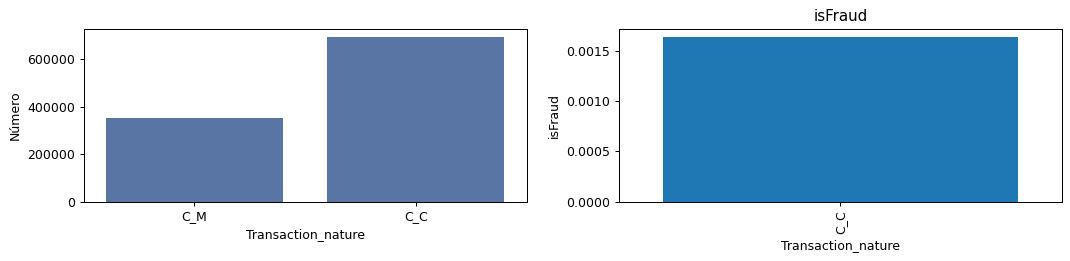

In [63]:
plot_feature(fraud_df, 'Transaction_nature')

In [66]:
print("Transacciones fraudulentas: ",fraud_df[fraud_df["isFraud"] == 1].Transaction_nature.value_counts())

Transacciones fraudulentas:  C_C    1142
Name: Transaction_nature, dtype: int64


First of all, as we can see, we only find customer-to-customer and customer-to-merchant transactions. Next we can see that there is only fraud in transactions made from client to client. This information is very important and will help us when preparing the model.

#### Zone, Device, Race y Gender

As we have seen previously, these variables are not very relevant, but we are going to quickly verify their distribution.

In [68]:
less_important_cat_variables = [ 'gender', 'device', 'race', 'zone']
less_important_cat_variables = fraud_df[less_important_cat_variables]

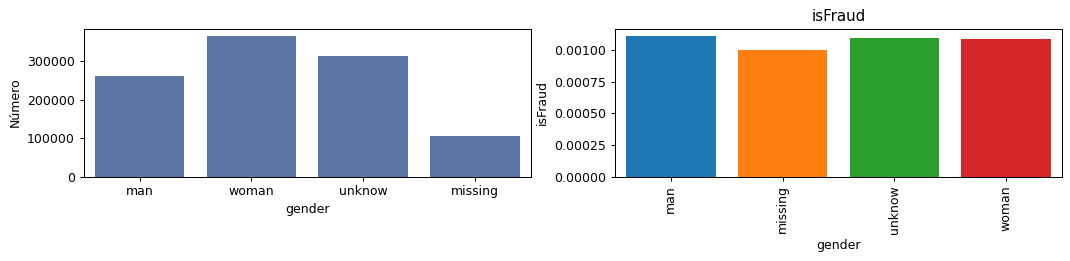

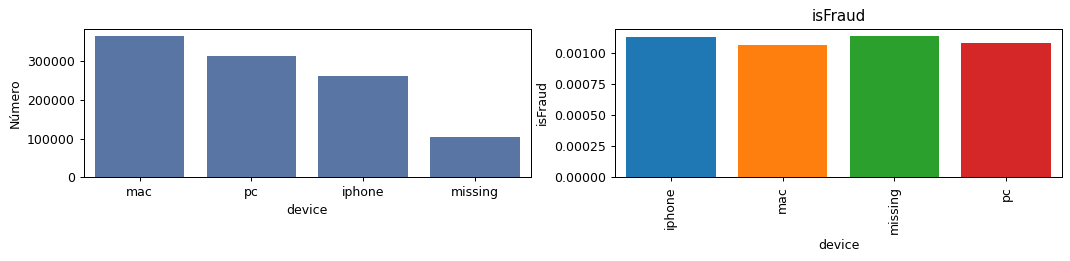

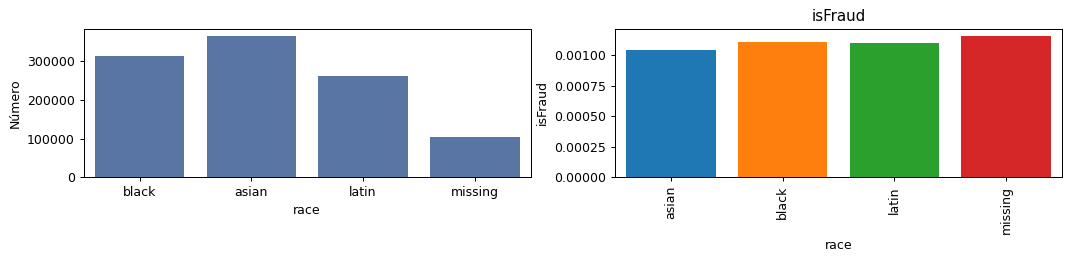

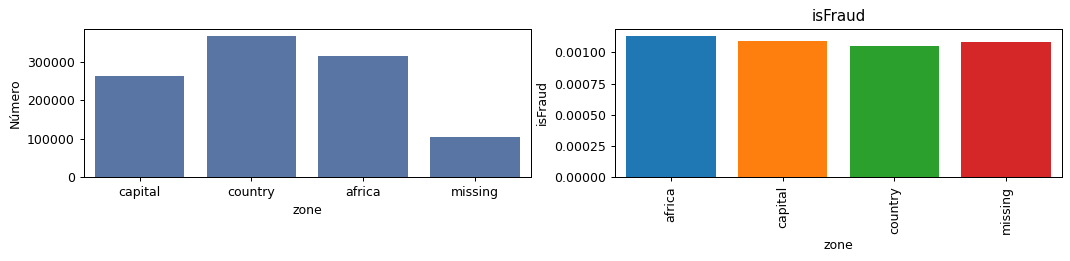

In [71]:
plot_several_features(less_important_cat_variables)

These variables, as we were predicting, have an equal distribution as far as the target variable is concerned. Therefore, they do not seem to be important variables when it comes to determining whether or not fraud has been committed.

### CONTINUOUS VARIABLES

To analyze the degree of association between these variables we will perform the Pearson correlation. The first thing that we will have to do, therefore, would correspond to the selection of the numerical variables. We can do it manually or we take the categorical variables and exclude them.

In [72]:
list_var_continuous = fraud_df.loc[:,~fraud_df.columns.isin(list(categorical_variables.columns))]
list_var_continuous.head()

,step,amount,connection_time,oldbalanceOrg,age,newbalanceOrig,user_number,user_connections,security_alert,oldbalanceDest,newbalanceDest,isFraud,Transaction_type,Transaction_nature
0,1,9839.64,0.140039,170136.0,85,160296.36,138,5,1,0.0,0.0,0,NaN,C_M
1,1,1864.28,0.496890,21249.0,57,19384.72,909,1,0,0.0,0.0,0,NaN,C_M
2,1,181.00,0.781150,181.0,66,0.00,2569,10,0,0.0,0.0,1,NaN,C_C
3,1,181.00,0.565068,181.0,31,0.00,1787,3,0,21182.0,0.0,1,NaN,C_C
4,1,11668.14,0.517114,41554.0,90,29885.86,3997,8,0,0.0,0.0,0,NaN,C_M


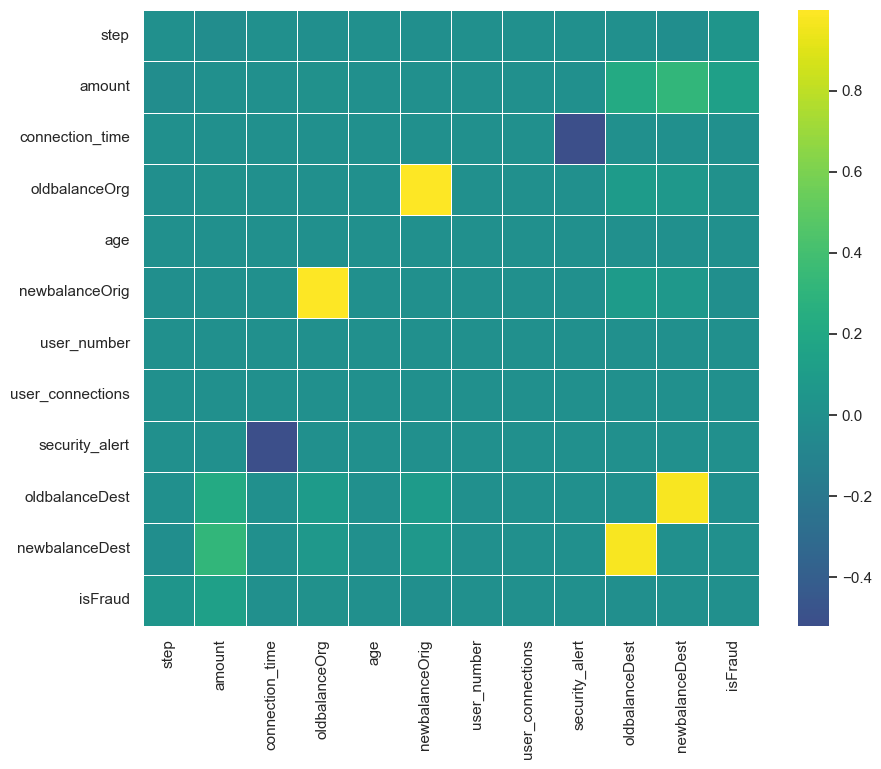

0

In [97]:
get_corr_matrix(dataset = list_var_continuous, metodo='pearson', size_figure=[10,8])

In [98]:
list_var_continuous.corr()

,step,amount,connection_time,oldbalanceOrg,age,newbalanceOrig,user_number,user_connections,security_alert,oldbalanceDest,newbalanceDest,isFraud
step,1.000000,-0.025996,0.001068,-0.006782,0.000201,-0.007182,-0.000356,-0.000140,-0.001313,-0.002251,-0.019502,0.045030
amount,-0.025996,1.000000,0.001755,0.004864,0.000076,-0.001132,0.001476,0.000579,-0.000490,0.215562,0.311942,0.128862
connection_time,0.001068,0.001755,1.000000,-0.001279,0.001739,-0.001342,-0.000450,0.000466,-0.520283,-0.000199,-0.000029,0.000290
oldbalanceOrg,-0.006782,0.004864,-0.001279,1.000000,0.000155,0.999050,0.000379,-0.001799,0.000091,0.093305,0.064050,0.003829
age,0.000201,0.000076,0.001739,0.000155,1.000000,0.000119,0.001168,0.000634,0.000363,0.000441,0.000377,0.000551
newbalanceOrig,-0.007182,-0.001132,-0.001342,0.999050,0.000119,1.000000,0.000351,-0.001844,0.000105,0.095179,0.063722,-0.009438
user_number,-0.000356,0.001476,-0.000450,0.000379,0.001168,0.000351,1.000000,-0.000554,-0.001604,-0.001038,-0.000588,-0.000821
user_connections,-0.000140,0.000579,0.000466,-0.001799,0.000634,-0.001844,-0.000554,1.000000,-0.000040,0.000902,0.001160,0.000764
security_alert,-0.001313,-0.000490,-0.520283,0.000091,0.000363,0.000105,-0.001604,-0.000040,1.000000,0.000824,0.000650,0.000265
oldbalanceDest,-0.002251,0.215562,-0.000199,0.093305,0.000441,0.095179,-0.001038,0.000902,0.000824,1.000000,0.978401,-0.007553


In this case we can see that certain variables have a high degree of correlation (newbalanceOrig - oldbalanceOrg, oldbalanceDest - newbalanceDest). Therefore, it will be these variables to which we pay more attention.

#### Individual variable analysis

#### Amount

Let's start with the amount to see if we find any relationship with the quantity. Fraud may occur in large or small amounts.

In [43]:
fraudulent_transactions = fraud_df.query("isFraud==1")

In [47]:
fraudulent_transactions.head(500)

,step,type,amount,gender,device,connection_time,nameOrig,race,oldbalanceOrg,age,newbalanceOrig,zone,user_number,nameDest,user_connections,security_alert,oldbalanceDest,newbalanceDest,isFraud,Transaction_nature
2,1,TRANSFER,181.00,man,pc,0.781150,C1305486145,asian,181.00,66,0.00,capital,2569,C553264065,10,0,0.00,0.00,1,C_C
3,1,CASH_OUT,181.00,man,mac,0.565068,C840083671,black,181.00,31,0.00,country,1787,C38997010,3,0,21182.00,0.00,1,C_C
251,1,TRANSFER,2806.00,unknow,pc,0.850314,C1420196421,asian,2806.00,90,0.00,africa,1413,C972765878,7,0,0.00,0.00,1,C_C
252,1,CASH_OUT,2806.00,missing,mac,0.331417,C2101527076,asian,2806.00,94,0.00,capital,2370,C1007251739,6,0,26202.00,0.00,1,C_C
680,1,TRANSFER,20128.00,woman,pc,0.762768,C137533655,asian,20128.00,6,0.00,country,3133,C1848415041,3,0,0.00,0.00,1,C_C
681,1,CASH_OUT,20128.00,man,mac,0.506713,C1118430673,asian,20128.00,85,0.00,africa,2963,C339924917,5,0,6268.00,12145.85,1,C_C
724,1,CASH_OUT,416001.33,man,missing,0.937052,C749981943,asian,0.00,10,0.00,africa,3470,C667346055,1,0,102.00,9291619.62,1,C_C
969,1,TRANSFER,1277212.77,woman,pc,0.738501,C1334405552,asian,1277212.77,48,0.00,africa,546,C431687661,5,0,0.00,0.00,1,C_C
970,1,CASH_OUT,1277212.77,woman,mac,0.416068,C467632528,black,1277212.77,7,0.00,africa,111,C716083600,2,0,0.00,2444985.19,1,C_C
1115,1,TRANSFER,35063.63,unknow,pc,0.812784,C1364127192,asian,35063.63,100,0.00,capital,4872,C1136419747,2,0,0.00,0.00,1,C_C


In [158]:
balance_variables = ['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

In [88]:
balance_df = fraudulent_transactions[balance_variables]
balance_df.head(50)

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
2,TRANSFER,181.00,181.00,0.00,0.00,0.00
3,CASH_OUT,181.00,181.00,0.00,21182.00,0.00
251,TRANSFER,2806.00,2806.00,0.00,0.00,0.00
252,CASH_OUT,2806.00,2806.00,0.00,26202.00,0.00
680,TRANSFER,20128.00,20128.00,0.00,0.00,0.00
681,CASH_OUT,20128.00,20128.00,0.00,6268.00,12145.85
724,CASH_OUT,416001.33,0.00,0.00,102.00,9291619.62
969,TRANSFER,1277212.77,1277212.77,0.00,0.00,0.00
970,CASH_OUT,1277212.77,1277212.77,0.00,0.00,2444985.19
1115,TRANSFER,35063.63,35063.63,0.00,0.00,0.00


As we can see and we have been announcing, it seems that there is a clear pattern when it comes to committing fraud. A transfer from c_c is made to an account with a certain amount, to then proceed to make the withdrawal or cash_out of that same amount, leaving the account at 0 (in most cases). Likewise, I believe that there is no specific pattern when it comes to determining whether the frauds committed involve a small or large amount, since we find frauds with high and smaller amounts. Important to keep this in mind.

Also, it is very important to note that when making a transfer with an exact amount to the balance of the source account, leaving the account at 0, and then making a cashout, it is likely to be fraud.

We will expand on this later.

In [89]:
balance_df_genuine = genuine_transactions[balance_variables]
balance_df_genuine.head(50)

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,PAYMENT,9839.64,170136.00,160296.36,0.0,0.00
1,PAYMENT,1864.28,21249.00,19384.72,0.0,0.00
4,PAYMENT,11668.14,41554.00,29885.86,0.0,0.00
5,PAYMENT,7817.71,53860.00,46042.29,0.0,0.00
6,PAYMENT,7107.77,183195.00,176087.23,0.0,0.00
7,PAYMENT,7861.64,176087.23,168225.59,0.0,0.00
8,PAYMENT,4024.36,2671.00,0.00,0.0,0.00
9,DEBIT,5337.77,41720.00,36382.23,41898.0,40348.79
10,DEBIT,9644.94,4465.00,0.00,10845.0,157982.12
11,PAYMENT,3099.97,20771.00,17671.03,0.0,0.00


#### Security Alert

Let's see if what we previously mentioned can be seen translated into security alerts.

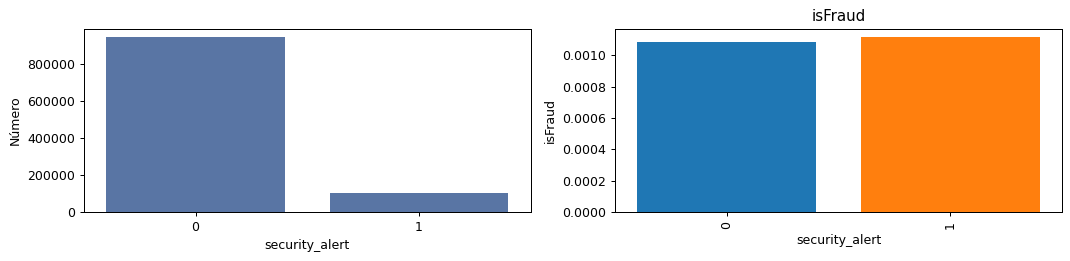

In [49]:
plot_feature(fraud_df, 'security_alert')

In this case, it is not a determining variable when it comes to deducing whether fraud has been committed, since we can see that it is equally distributed between fraud and non-fraud.

#### User Connections

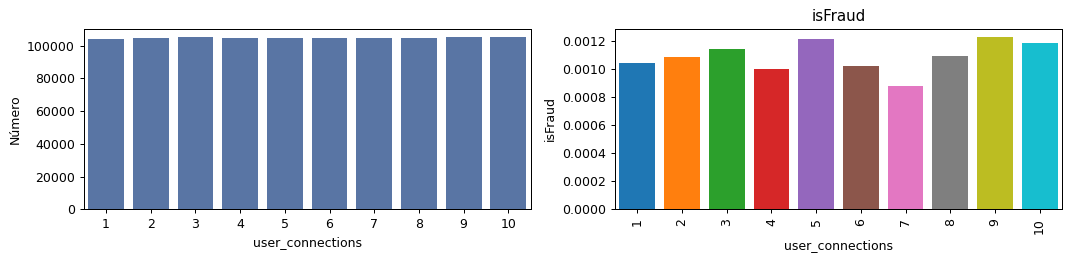

In [52]:
plot_feature(fraud_df, 'user_connections')

It seems that when more fraud is committed is when 5 user connections are made. However, I do not find it as a determining variable as it is nearly equally distributed towards target variable.

#### Age

<AxesSubplot:xlabel='age', ylabel='Count'>

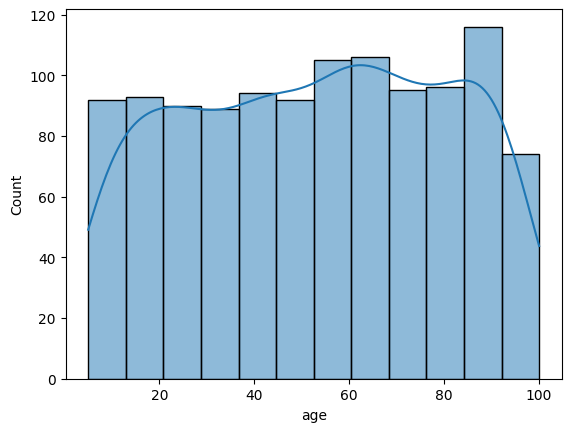

In [61]:
sns.histplot(x = 'age', data = fraudulent_transactions, kde=True)

It seems that it is distributed equally, although we found curious data such as that there are fraudulent transactions carried out by people aged 100 or under 18, which is quite strange.

#### Step

<AxesSubplot:xlabel='step'>

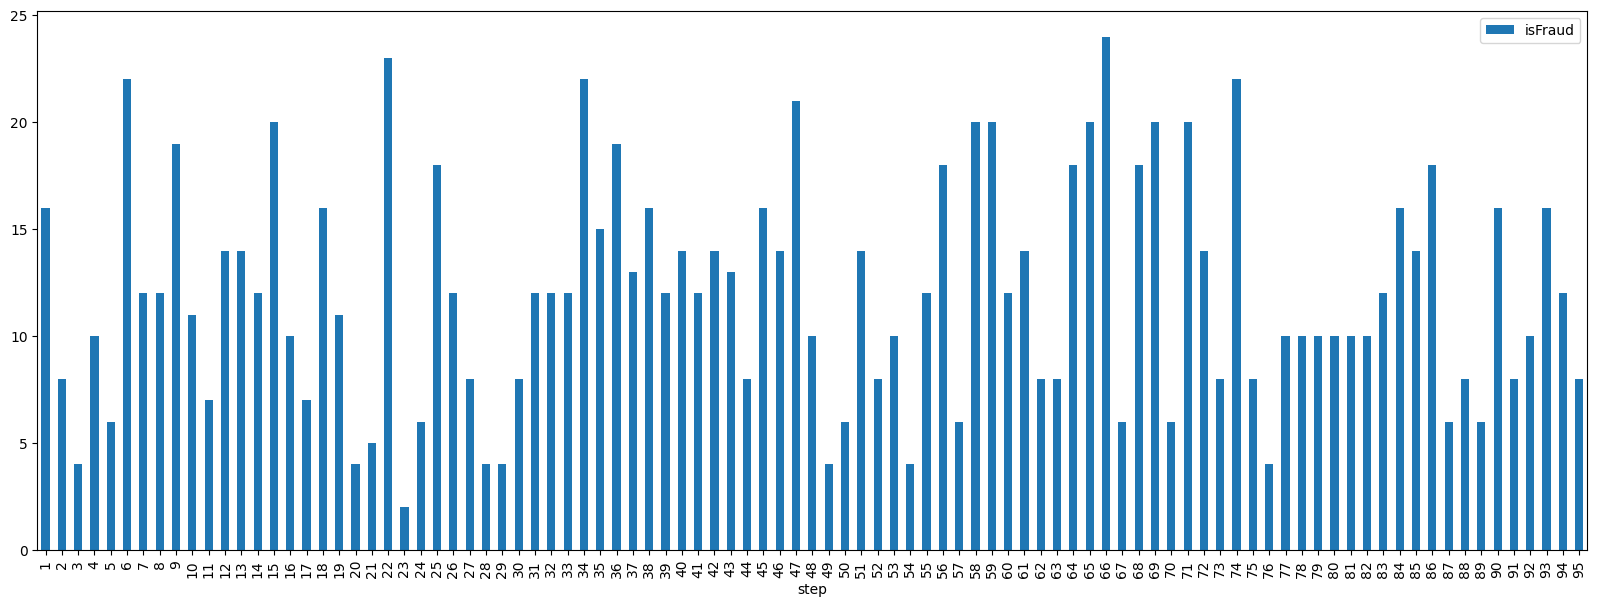

In [66]:
fraudulent_transactions[['isFraud','step']].groupby('step').count().plot(kind='bar',figsize=(20,7))

I don't see that it follows a specific pattern. In any case, we will see the importance of this variable later, if it has.

I consider it quite logical that if fraud is committed, another fraud will not be carried out again from the same account.

## FINAL CONCLUSION


1- The dataset is quite unbalanced since we find very few cases of fraud committed if we compare it with the total data. We'll see what we can do to balance it out.
 
 2- We can determine that fraud is carried out from client to client. Only in these cases does fraud occur, so close attention must be paid to this type of transaction.
 
 3- We find ourselves with a certain number of variables that do not seem to be of considerable importance when it comes to determining whether or not there is fraud. We will see in the selection of variables what their importance is but I consider that they will have little importance.
 
 4- There is a clear pattern of fraud that occurs in most cases. A transfer is made to an account x to later make a cash out of that same amount and leave the account at 0.
 
 5- It is very important to pay attention to (if I had to draw a conclusion right now for the client) the transfers made from client to client, leaving a balance in the original account of 0 and then making a cashout.
 
 

For this we are going to make the following dataframe to verify if the conclusions are correct.

In [174]:
veracity_conclusion =  fraud_df[(fraud_df.amount == fraud_df.oldbalanceOrg) & (fraud_df.newbalanceOrig == 0) & fraud_df.isFraud == 1]
veracity_conclusion.head(50)

,step,type,amount,gender,device,connection_time,nameOrig,race,oldbalanceOrg,age,newbalanceOrig,zone,user_number,nameDest,user_connections,security_alert,oldbalanceDest,newbalanceDest,isFraud,Transaction_nature
2,1,TRANSFER,181.00,man,pc,0.781150,C1305486145,asian,181.00,66,0.0,capital,2569,C553264065,10,0,0.00,0.00,1,C_C
3,1,CASH_OUT,181.00,man,mac,0.565068,C840083671,black,181.00,31,0.0,country,1787,C38997010,3,0,21182.00,0.00,1,C_C
251,1,TRANSFER,2806.00,unknow,pc,0.850314,C1420196421,asian,2806.00,90,0.0,africa,1413,C972765878,7,0,0.00,0.00,1,C_C
252,1,CASH_OUT,2806.00,missing,mac,0.331417,C2101527076,asian,2806.00,94,0.0,capital,2370,C1007251739,6,0,26202.00,0.00,1,C_C
680,1,TRANSFER,20128.00,woman,pc,0.762768,C137533655,asian,20128.00,6,0.0,country,3133,C1848415041,3,0,0.00,0.00,1,C_C
681,1,CASH_OUT,20128.00,man,mac,0.506713,C1118430673,asian,20128.00,85,0.0,africa,2963,C339924917,5,0,6268.00,12145.85,1,C_C
969,1,TRANSFER,1277212.77,woman,pc,0.738501,C1334405552,asian,1277212.77,48,0.0,africa,546,C431687661,5,0,0.00,0.00,1,C_C
970,1,CASH_OUT,1277212.77,woman,mac,0.416068,C467632528,black,1277212.77,7,0.0,africa,111,C716083600,2,0,0.00,2444985.19,1,C_C
1115,1,TRANSFER,35063.63,unknow,pc,0.812784,C1364127192,asian,35063.63,100,0.0,capital,4872,C1136419747,2,0,0.00,0.00,1,C_C
1116,1,CASH_OUT,35063.63,missing,iphone,0.054131,C1635772897,asian,35063.63,99,0.0,capital,2414,C1983025922,7,1,31140.00,7550.03,1,C_C


In [186]:
print(len(veracity_conclusion), 'observations follow the rule', 'in front of'
      , len(fraudulent_transactions), 'real fraudulent transactions')

1109 observations follow the rule in front of 1142 real fraudulent transactions


As we can see, this occurs in 1,109 cases out of 1,142. Therefore, the pattern of fraud is extremely clear.

### CSV Export

Once finished with the EDA we proceed to save the file that will be used later.

In [185]:
fraud_df

,step,type,amount,gender,device,connection_time,nameOrig,race,oldbalanceOrg,age,newbalanceOrig,zone,user_number,nameDest,user_connections,security_alert,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,man,mac,"0,140039412",C1231006815,black,170136.00,85,160296.36,capital,138,M1979787155,5,1,0.00,0.00,0
1,1,PAYMENT,1864.28,woman,mac,"0,496889534",C1666544295,asian,21249.00,57,19384.72,country,909,M2044282225,1,0,0.00,0.00,0
2,1,TRANSFER,181.00,man,pc,"0,781150327",C1305486145,asian,181.00,66,0.00,capital,2569,C553264065,10,0,0.00,0.00,1
3,1,CASH_OUT,181.00,man,mac,"0,565068378",C840083671,black,181.00,31,0.00,country,1787,C38997010,3,0,21182.00,0.00,1
4,1,PAYMENT,11668.14,unknow,mac,"0,517114493",C2048537720,black,41554.00,90,29885.86,country,3997,M1230701703,8,0,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,95,CASH_OUT,132557.35,woman,mac,"0,420243195",C1179511630,black,479803.00,39,347245.65,NaN,3179,C435674507,9,0,484329.37,616886.72,0
1048571,95,PAYMENT,9917.36,woman,mac,"0,37616924",C1956161225,black,90545.00,36,80627.64,africa,2558,M668364942,9,0,0.00,0.00,0
1048572,95,PAYMENT,14140.05,unknow,pc,"0,837108874",C2037964975,black,20545.00,31,6404.95,africa,1553,M1355182933,2,0,0.00,0.00,0
1048573,95,PAYMENT,10020.05,man,mac,"0,480931208",C1633237354,black,90605.00,94,80584.95,country,642,M1964992463,8,0,0.00,0.00,0


In [183]:
fraud_df.to_csv(csv_outpath)